# Explainer Notebook - Project in 42578 Advanced Business Analytics
This notebook was formed as a part of the final project in Advanced Business Analytics course 42578 at DTU.

Team members:

- Daniel Ries (s214641)
- Karoline Klan Hansen (s214638)
- Kristoffer Helms Kjær (s214609)
- Felix Lund Frandsen (s214584)

Relevant Links:

Visit the [**Executive Summary**](#) for a high-level overview of the project, tailored to a non-technical business audience.
For full source code and project structure, visit the [**project GitHub repository**](https://github.com/KarolineKlan/advanced_ba_project). That is based on the [mlops cookie cutter template](https://github.com/SkafteNicki/mlops_template).

# Table of Contents
* [1. Introduction](#chapter1)
    * [1.1 Motivation and Objective](#section_1_1)
    * [1.2 Scope](#section_1_2)


* [2. The Data Foundation](#chapter2) Karo
    * [2.1 Deep Globe](#section_2_1) Karo
    * [2.2 Roboflow ](#section_2_2) Karo 
    * [2.2 Google Engine](#section_2_3) Felix
   
* [3. Defining the Model, Baseline, and Tuning Strategy](#chapter3) 
    * [3.1 U-Net Architecture](#section_3_1) Daniel
    * [3.2 Baseline](#section_3_2) Daniel
    * [3.3 Training and Hyperparameter Optimization](#section_3_3) Kri

* [4. Evaluation and Results](#chapter4) Kri, Daniel + evt andre

* [5. Discussion and Conclusions](#chapter5)

* [6. References](#chapter6)

* [7. Contribution Statement](#chapter7)

***

# 1. Introduction <a class="anchor" id="chapter1"></a>

## 1.1 Motivation and Objective <a id="section_1_1"></a>

Deforestation is a significant driver of biodiversity loss and climate change. According to Our World in Data, deforestation has led to the loss of over 10 million hectares of forest annually in recent years, primarily driven by agriculture, logging, and infrastructure expansion [[1](#chapter6)]. Recognizing the urgency of this issue, the European Union has introduced the EU Deforestation Regulation (EUDR), which mandates stricter tracking and reporting of deforestation-linked resources [[2](#chapter6)]. 

This project aims to develop an AI-powered segmentation model to distinguish forests from non-forested areas in satellite images. This would lay the foundation for tracking land cover changes, which can later be integrated with a classification model to assess deforestation trends.

## 1.2 Scope <a id="section_1_2"></a>


This project serves as a minimal viable product for applying AI to deforestation monitoring through satellite imagery. The current focus is on training a segmentation model to detect forested areas in satellite images of lower resolution.

To move toward real-world application, future work would involve integrating time-series satellite data to track forest changes over time and adapting the model to handle larger, high-resolution satellite images. The long-term potential is to support businesses, particularly in forestry and agriculture, in identifying deforestation in high-risk areas and demonstrating compliance with regulations from EUDR.


1) **Current Step - Detection:** We train a deep learning model to segment forests from satellite images.


2) **Next Step - Monitoring:** Combine the segmentation model with time-series satellite imagery to analyze forest cover changes over time.


3) **Future Use Case - Compliance:** Apply this model to real-world deforestation tracking to help businesses comply with EUDR regulations.


In [ ]:
import os
import random
import sys
import time
from pathlib import Path

sys.path.append(str(Path("../src").resolve()))

import ee
import hydra
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm

from advanced_ba_project.data import ForestDataset, get_dataloaders, summarize_raw_data, visualize_raw_data

***


# 2. The Data Foundation <a class="anchor" id="chapter2"></a>

## 2.1 Deep Globe  <a id="section_2_1"></a>

The Forest Segmentation dataset used originates from the DeepGlobe 2018 Land Cover Classification Challenge [[3](#chapter6)], based on satellite imagery from Thailand, Indonesia, India, Bangladesh, and parts of the Middle East & North Africa. The dataset is a subset dreived from kaggle [[4](#chapter6)] and it consists of patches in a lower resolution than the original and does not include geolocation metadata. While the masks can be coarse and imperfect due to the downsampling as also apparent in the images below, we find the dataset well-suited for this project as it enables faster model training compared to using the original high-resolution images. 

The training dataset comprises **5108** training images, each sized **256×256** pixels all with areas of forest on them. View the dataloader in [`data.py`](https://github.com/KarolineKlan/advanced_ba_project/blob/main/src/advanced_ba_project/data.py) for more details of how the data is loaded and preprocessed.


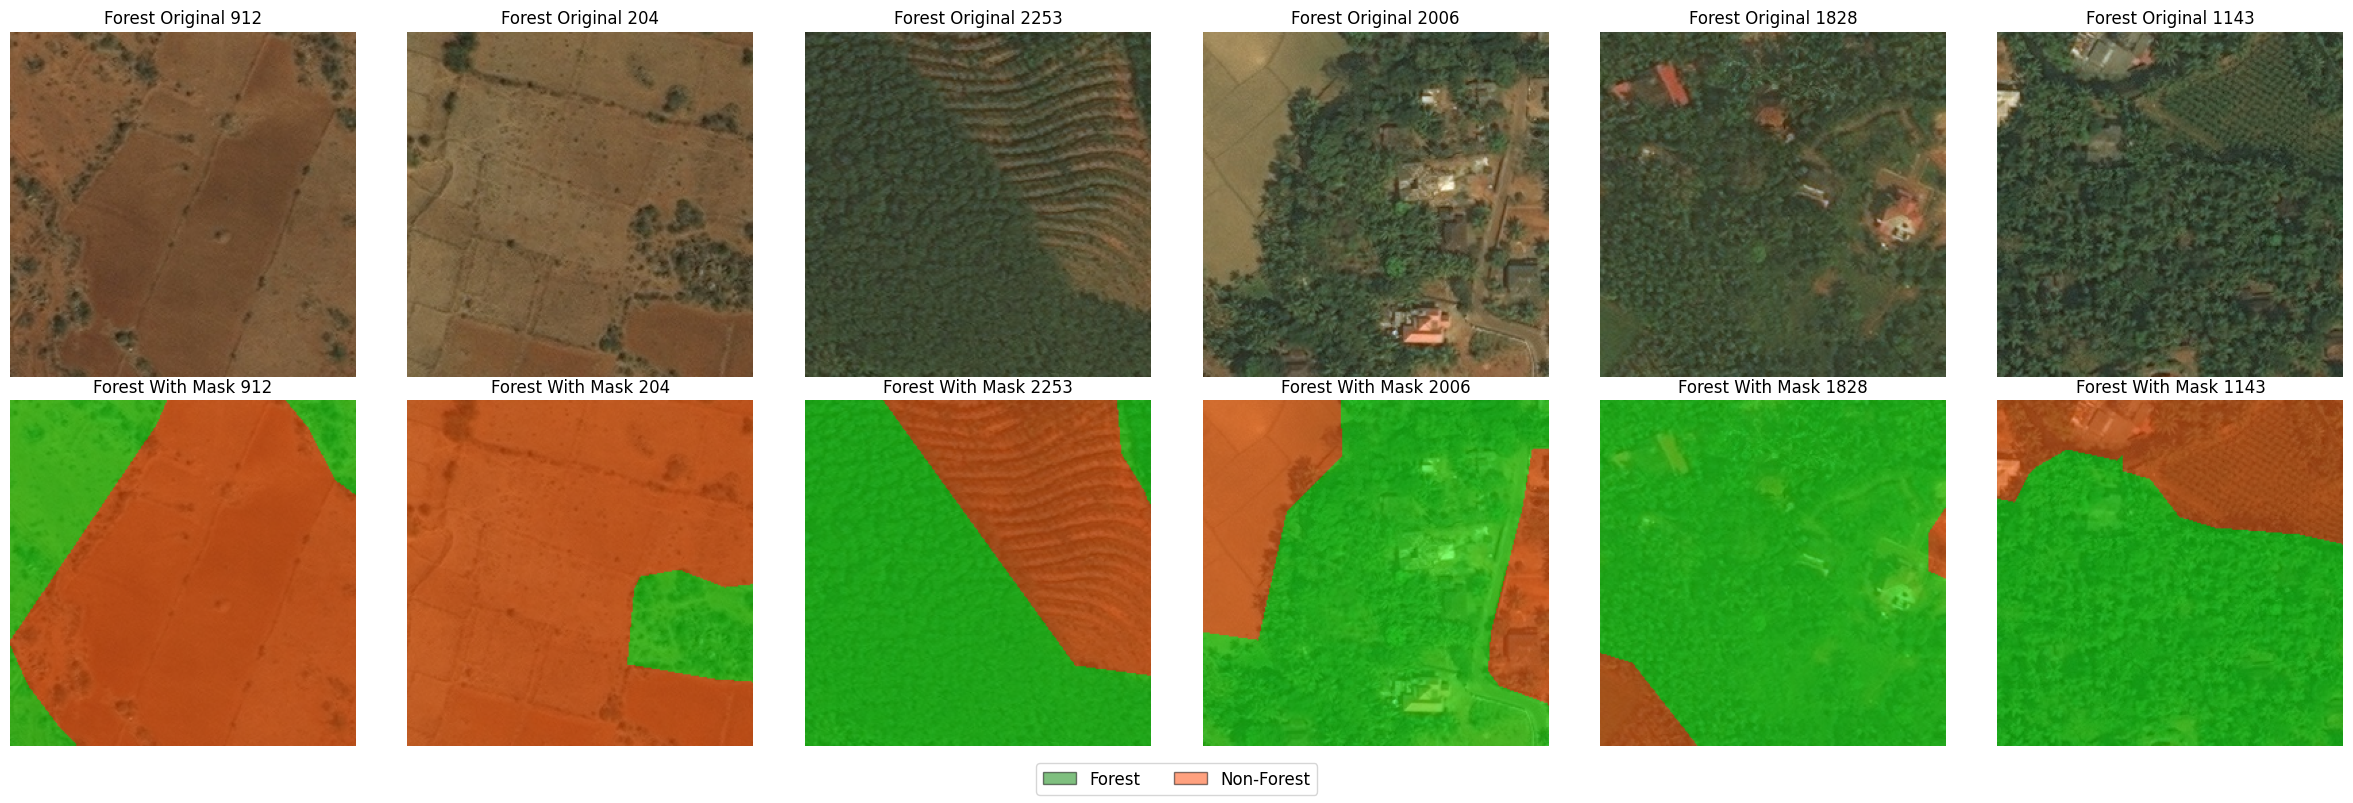

In [5]:
visualize_raw_data(
    dataset_name="forest",
    data_path=Path("../data/raw/Forest Segmented"),
    metadata_file="meta_data.csv",
    num_images=6,
    seed=42
)

## 2.2 Roboflow  <a id="section_2_2"></a>

To complement the DeepGlobe dataset, we incorporate additional data from the Roboflow platform's Deforestation Satellite Imagery project [[8](#chapter6)]. Including this data adds variety by including more urban and mixed environments, helping the model generalize better across different areas and conditions.
The 1751 original 512×512 images are resized to match the DeepGlobe resolution (256×256) for consistency in model training. Unlike the masks in DeepGlobe, the forest annotations here are derived from polygon labels, resulting in sharper and more detailed but also more sparse segmentation masks. 

The training dataset consists of **7004** image patches, approximately 83% of which contain forest annotations, others do not include any trees as seen in the visual beelow. See the dataloader in [`data.py`](https://github.com/KarolineKlan/advanced_ba_project/blob/main/src/advanced_ba_project/data.py) for implementation details.

100%|██████████| 7004/7004 [00:23<00:00, 295.51it/s]


Dataset: roboflow
Total samples: 7004
Amount of samples with forest: 5831 (83.25%)


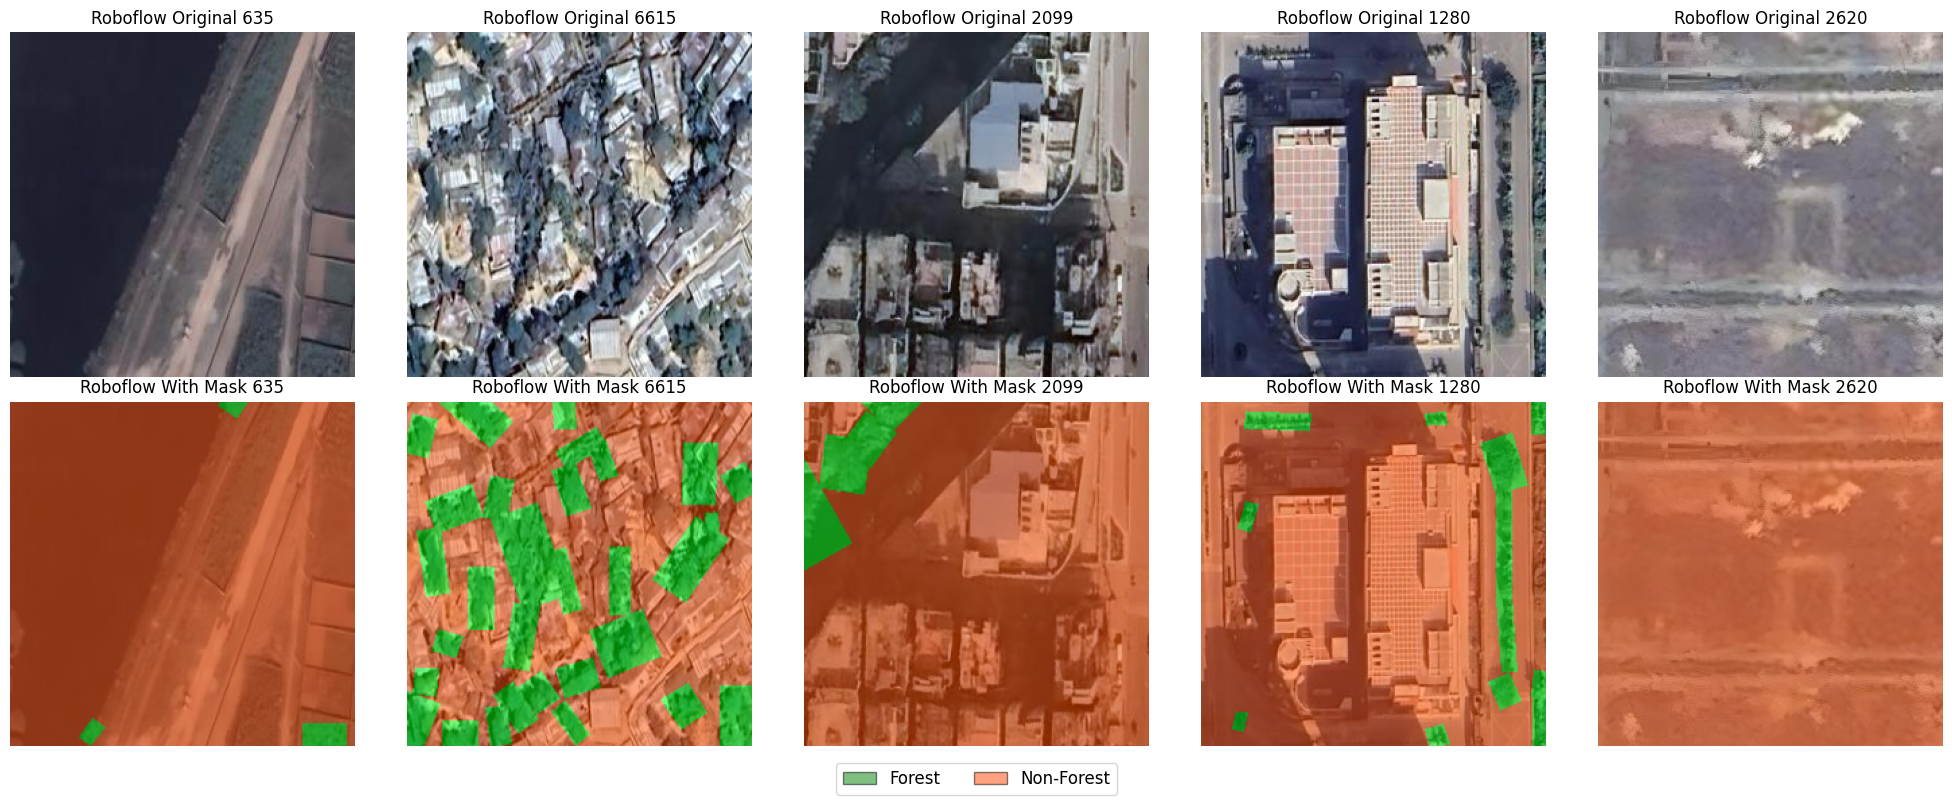

In [7]:
summarize_raw_data(
    dataset_name="roboflow",
    image_dir=Path("../data/raw/roboflow/train/images"),
    label_dir=Path("../data/raw/roboflow/train/labelTxt")
)

visualize_raw_data(
    dataset_name="roboflow",
    data_path=None,
    image_dir=Path("../data/raw/roboflow/train/images"),
    label_dir=Path("../data/raw/roboflow/train/labelTxt"),
    seed=112233
)

## 2.3 Google Engine API  <a id="section_2_3"></a>


In addition to the static training datasets, we explored the use of satellite imagery retrieved directly via the Google Earth Engine API [[5](#chapter5)]. We developed a script to query the google earth engine api and through that download high-resolution aerial images from the USDA NAIP dataset across multiple locations and time points. The goal was to test the model on real-world, timestamped imagery and assess its potential for temporal deforestation detection.

Due to processing, and the manual nature of labelling, this dataset was only used for small scale proof of concept testing.

The region of interest is arbitrarily chosen as a ~55x55 km area in California, which is divided into 256×256 pixel tiles at 0.6-meter resolution (153.6m x 153.6m per tile). From the full grid, 100 tiles are randomly selected to ensure spatial variation.

For each selected tile, imagery is requested at seven specific timestamps (from 2004 to 2022). The script retrieves the NAIP image closest to each target date (within ± 180 days), ensuring consistency across years. Each image is clipped to the tile boundaries and exported to Google Drive.


In [ ]:

# Initialize Earth Engine - It is necessary to authenticate and initialize the Earth Engine API
# using google account credentials as seen in the code below.
ee.Initialize(project='ee-felixlundfrandsen')

# Define region of interest
roi = ee.Geometry.Rectangle([-120.0, 37.0, -119.5, 37.5])  # ~55 km x 55 km

# Define tile size in meters (256x256 pixels at 0.6m resolution)
grid_size_meters = 153.6

# Generate fixed-size tiles over the ROI
def create_tiles(roi, grid_size_meters):
    tiles = []
    coords = roi.bounds().coordinates().getInfo()[0]
    lon_min, lat_min = coords[0]
    lon_max, lat_max = coords[2]

    deg_per_meter = 1 / 111320
    step = grid_size_meters * deg_per_meter

    num_tiles_x = int((lon_max - lon_min) / step)
    num_tiles_y = int((lat_max - lat_min) / step)

    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            lon1 = lon_min + i * step
            lat1 = lat_min + j * step
            lon2 = lon1 + step
            lat2 = lat1 + step
            bbox = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])
            tiles.append(bbox)

    return tiles

# Create and select 100 random tiles
tiles = create_tiles(roi, grid_size_meters)
random.shuffle(tiles)
tiles = tiles[:100]

# Define image acquisition dates
timestamps = [
    "2004-07-05", "2006-07-07", "2009-06-22",
    "2012-06-28", "2016-06-30", "2020-06-26", "2022-08-10"
]

# Export configuration
scale = 0.6
folder_name = "EarthEngine_NAIP_MultiTiles"

# Select closest image within ±180 days of target date
def get_naip_image(target_date, tile):
    target = ee.Date(target_date)
    start = target.advance(-180, 'day')
    end = target.advance(180, 'day')

    collection = ee.ImageCollection("USDA/NAIP/DOQQ") \
        .filterDate(start, end) \
        .filterBounds(tile) \
        .map(lambda img: img.set("date_diff", img.date().difference(target, 'day').abs())) \
        .sort("date_diff")

    return collection.first()

# Export imagery for each tile and timestamp
for tile_index, tile in enumerate(tiles):
    area_id = f"area_{str(tile_index).zfill(3)}"

    for date in timestamps:
        year = date[:4]
        file_prefix = f"{area_id}_{year}_{date.replace('-', '')}"

        image = get_naip_image(date, tile)

        if image:
            image = image.select(['R', 'G', 'B'])

            task = ee.batch.Export.image.toDrive(
                image=image.clip(tile),
                description=file_prefix,
                folder=folder_name,
                fileNamePrefix=file_prefix,
                region=tile,
                crs='EPSG:4326',
                scale=scale,
                maxPixels=1e9
            )

            task.start()
            print(f"Started export: {file_prefix}")
        else:
            print(f"No image found for {file_prefix}, skipping...")

print("\nAll export tasks submitted. Monitor progress at https://code.earthengine.google.com/tasks")


Insert the 6-10 images Felix as markdown image:

![]()

***

# 3. Defining the Model, Baseline, and Tuning Strategy <a class="anchor" id="chapter3"></a>
In this section, we outline the model architecture used for segmentation, define a simple baseline for comparison, and describe the hyperparameter tuning strategy applied during training.


## 3.1 The U-net Architecture <a id="section_3_1"></a>

U-Net is a convolutional neural network architecture that is especially good for semantic segmentation tasks, where the goal is to assign a class label to each pixel in an image. 

The architecture follows a symmetric encoder–decoder structure:
- The encoder (contracting path) captures the context of the image using convolution and max-pooling layers.
- The decoder (expanding path) enables precise localization through upsampling and concatenation with high-resolution features from the encoder (via skip connections). (Image source: [[6](#chapter5)])

<figure>
    <div style="text-align: center;">
        <img src="Unet_architecture.png" width="60%" alt="Unet">
    </div>
    <figcaption style="text-align: left; font-style: italic; font-size: smaller;">
        Figure 1: U-net architecture (example for 32×32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations. (Image caption source: [[6](#chapter5)])
    </figcaption>
</figure>


Note that the image above is for illustrative purposes and does not reflect the exact dimensions used in our implementation. For the specific architecture applied in this project, refer to the [`model.py`](https://github.com/KarolineKlan/advanced_ba_project/blob/main/src/advanced_ba_project/model.py) script. The implementation is heavily inspired by materials from a DTU 3-week course [[7](#chapter5)].


## 3.2 Baseline <a id="section_3_2"></a>  

To evaluate the performance of our U-Net deforestation model, we define a baseline that classifies each pixel as forest if its green channel value is greater than both the red and blue channels.

We define the baseline model as a function that takes in a pixel and returns 1 if the pixel is more green than red and blue, otherwise it returns 0. Also, we include a threshold parameter that allows us to adjust the sensitivity of the model. The threshold is a value between 0 and 1, where 0 means that the pixel must be completely green to be classified as a tree, and 1 means that the pixel can be any color to be classified as a tree. We also have an evaluation function so we can compare the baseline to the deforestation model.

In [ ]:
def green_tree_detector(image_batch, threshold=0.1):
    """
    Simple baseline that detects trees based on green channel values.

    Args:
        image_batch: Tensor of shape [batch_size, 3, 256, 256]
        threshold: How much greener a pixel must be compared to other channels

    Returns:
        Tensor of shape [batch_size, 1, 256, 256] with binary tree mask
    """
    batch_size = image_batch.shape[0]
    device = image_batch.device

    # Extract RGB channels
    r = image_batch[:, 0]  # Red channel
    g = image_batch[:, 1]  # Green channel
    b = image_batch[:, 2]  # Blue channel

    # Consider a pixel a tree if green value is dominant
    # g > r + threshold AND g > b + threshold
    tree_mask = ((g > (r + threshold)) & (g > (b + threshold))).float()

    # Reshape to [batch_size, 1, 256, 256] to match ground truth format
    return tree_mask.unsqueeze(1)

We also include an evaluation function so we can directly compare this baseline to the U-Net model:

In [ ]:
def evaluate_detector(dataloader, threshold=0.1):
    """Evaluate the green tree detector on the given dataloader."""
    device = next(iter(dataloader))[0].device

    # Initialize metrics
    total_pixels = 0
    metrics = {
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'iou': 0
    }

    # Process each batch
    for images, masks in tqdm(dataloader, desc="Evaluating baseline detector"):
        # Generate predictions
        predictions = green_tree_detector(images, threshold=threshold)

        # Convert to binary predictions (0 or 1)
        pred_binary = (predictions > 0.5).float()

        # Flatten tensors for metric calculation
        pred_flat = pred_binary.cpu().numpy().flatten().astype(int)
        mask_flat = masks.cpu().numpy().flatten().astype(int)

        # Update metrics
        batch_pixels = pred_flat.shape[0]
        total_pixels += batch_pixels

        metrics['accuracy'] += accuracy_score(mask_flat, pred_flat) * batch_pixels
        metrics['precision'] += precision_score(mask_flat, pred_flat, zero_division=0) * batch_pixels
        metrics['recall'] += recall_score(mask_flat, pred_flat, zero_division=0) * batch_pixels
        metrics['f1'] += f1_score(mask_flat, pred_flat, zero_division=0) * batch_pixels
        metrics['iou'] += jaccard_score(mask_flat, pred_flat, zero_division=0) * batch_pixels

    # Calculate final metrics
    for key in metrics:
        metrics[key] /= total_pixels

    return metrics

## 3.3 Training and Hyperparameter Optimization <a id="section_3_3"></a>  

To improve model performance, we performed hyperparameter tuning using a grid search strategy via Weights & Biases Sweeps. The optimization targeted validation F1 score, aiming to maximize it. The code for the sweep was defined in [`sweep.py`](https://github.com/KarolineKlan/advanced_ba_project/blob/main/src/advanced_ba_project/sweep.py). During training, we also experimented with data augmentation, applying random horizontal and vertical flips as well as 90°, 180°, or 270° rotations to both images and masks - see the dataloader in [`data.py`](https://github.com/KarolineKlan/advanced_ba_project/blob/main/src/advanced_ba_project/data.py) for more information about the augmentation.

The loss function used for training the model was a combination of Dice loss and Binary Cross-Entropy (BCE) loss—referred to as DiceBCELoss. The BCE loss is well-suited for binary segmentation and therefore works well for the pixel-wise classification of forrest and non-forrest regions. The Dice loss focuses on the overlap between predicted masks and the ground truth, which is particularly important when the classes are imbalanced - a characteristic of our dataset, where non-forest pixels significantly outnumber forest pixels.
For optimization, we used the Adam optimizer with weight decay to regularize the model and prevent overfitting. Additionally, a ReduceLROnPlateau learning rate scheduler was implemented to dynamically adjust the learning rate based on the validation loss. Specifically, the learning rate was reduced by a factor of 0.5 if the validation loss did not improve for three consecutive epochs.

To further mitigate overfitting, dropout was applied within the model architecture, helping to improve generalization by preventing the model from relying too heavily on specific neurons during training.

In the sweep we searched over combinations of:

- `batch_size`: 16, 32
- `learning_rate`: 0.001, 0.0001
- `weight_decay`: 0.001, 0.0001
- `dropout_rate`: 0.1, 0.2, 0.3
- `apply_augmentation`: true, false

This results in a total of 48 runs in this sweep. The dataset used for training and validation consists of a combination of the DeepGlobe and Roboflow datasets, split into 80% training (11,090 images), 10% validation (1,110 images), and 10% test (1,012 images). 
In the image below, the results of the sweep are illustrated. The "iconic-sweep-16" run, turned out to be the optimally trained model with the best F1 score and accuracy. The optimal hyperparameters found through the sweep are thus:

- `batch_size`: 32
- `learning_rate`: 0.0001
- `weight_decay`: 0.0001
- `dropout_rate`: 0.1
- `apply_augmentation`: true


<figure>
    <div style="text-align: center;">
        <img src="sweep.png" width="100%" alt="Unet">
    </div>
    <figcaption style="text-align: left; font-style: italic; font-size: smaller;">
        Figure 2: Sweep results from Weights & Biases. The best run of the sweep is highlighted.
    </figcaption>
</figure>

The final model was trained using these hyperparameters over 100 epochs. As seen in the image below, the training converged succesfully without overfitting the model as seen on the training and validation loss curves. Furthermore, the accuracy and F1 score have plateaued. 

<table>
  <tr>
    <td>
      <img src="loss_train.png" width="400"><br>
    </td>
    <td>
      <img src="loss_val.png" width="400"><br>
    </td>
  </tr>
  <tr>
    <td>
      <img src="val_acc.png" width="400"><br>
    </td>
    <td>
      <img src="val_f1.png" width="400"><br>
    </td>
  </tr>
</table>


Finally, after training the model was tested on a seperate test set to the a final completely unbiased evaluation of the model performance. This led to the following results:

- `accuracy`: 0.8797230173947783
- `f1`: 0.8470773882836613
- `precision`: 0.8169849727583002
- `recall`: 0.8827186953571795
- `iou`: 0.7369579061305241


***

# 4. Evaluation & Results <a class="anchor" id="chapter4"></a>

The U-net segmentation model was compared with a simple baseline model to evaluate it's perfomance. Both models were evaluated on the same test set of images with the standard classification metrics of accuracy, precision, recall, and F1 score. 
The metrics for the baseline model and U-net segmentation model can be seen in the table below:

| Metric     | Baseline | Unet  |
|------------|----------|-------|
| Accuracy   | 0.7384   |       |
| Precision  | 0.6744   |       |
| Recall     | 0.4607   |       |
| F1 Score   | 0.5422   |       |



The baseline model has a 73.84% accuracy, a precision of 67.44%, a recall of 46.07%, and an F1 score of 54.22%. In comparison, the U-net model...

- prediction billeder for både baseline (samme format oppe i data) - aftal hvilke ID billeder i bruger!

- Prediction billeder på API billederne


***

# 5. Discussion and Conclusions <a class="anchor" id="chapter5"></a>

Stuff to mention:
- Mixing of two datasets? how does it affect training that we included samples without forrest on it?
- The low resolution images: in real world scenario we would likely manage larger geographical areas, meaning tha model As is should be able to take in larger images, or process many small at a time and stich together in a larger area/image.
- quality of free API sattelite images - not from every year, only from US?
- More?
- ?


*** 

# 6. References <a class="anchor" id="chapter6"></a>

[1] Our World in Data, “Deforestation,” 2024. [Online]. Available: https://ourworldindata.org/deforestation. [Accessed: Mar. 26, 2025].


[2] European Commission, “Regulation on deforestation-free products,” 2024. [Online]. Available: https://environment.ec.europa.eu/topics/forests/deforestation/regulation-deforestation-free-products_en. [Accessed: Mar. 26, 2025].

[3] I. Demir, K. Koperski, D. Lindenbaum, G. Pang, J. Huang, S. Basu, F. Hughes, D. Tuia, and R. Raskar, “DeepGlobe 2018: A Challenge to Parse the Earth through Satellite Images,” in *2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW)*, Salt Lake City, UT, USA, Jun. 2018, pp. 172–17209. [Online]. Available: http://dx.doi.org/10.1109/CVPRW.2018.00031

[4] Q. Ahmed, “Augmented Forest Segmentation,” Kaggle, 2022. [Online]. Available: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation. [Accessed: Mar. 26, 2025].

[5] Google Developers, “Google Earth Engine,” 2024. [Online]. Available: https://developers.google.com/earth-engine. [Accessed: Mar. 26, 2025].

[6] O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation,” in *Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015*, vol. 9351, Springer, 2015, pp. 234–241. [Online]. Available: https://arxiv.org/abs/1505.04597

[7] R. R. Paulsen, “DTU U-net course,” GitHub repository, 2023. [Online]. Available: https://github.com/RasmusRPaulsen/DTU-U-net-course. [Accessed: Mar. 26, 2025].

[8] Roboflow: CSE499DeforestationSatellite, “Deforestation-Satellite-Imagery Dataset,” Roboflow Universe, Roboflow - Open source dataset, Jan. 2025. [Online]. Available: https://universe.roboflow.com/cse499deforestationsatellite/deforestation-satellite-imagery-335n4. [Accessed: Apr. 15, 2025].



# 6. Contribution Statement <a class="anchor" id="chapter6"></a>